# <ins>**Student Grade Predictor**</ins>

## <ins>**Initialization**</ins>

In [85]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
%matplotlib inline
sc = StandardScaler()
students = pd.read_csv('student_list.csv')
students.head()

,StudentID,Age,StudyTimeWeekly,Absences,ParentalSupport,GPA,GradeClass
0,1002,18,15.408756,0,1,3.042915,1
1,1003,15,4.210570,26,2,0.112602,4
2,1004,17,10.028829,14,3,2.054218,3
3,1005,17,4.672495,17,3,1.288061,4
4,1006,18,8.191219,0,1,3.084184,1


## <ins>**Data Wrangling**</ins>

### Replacing number with letters

In [86]:
# List of grades
grades = ['A', 'B', 'C', 'D', 'F']

# Replace numerical representation of grades to letter representation
students['GradeClass'] = students['GradeClass'].replace({
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'F'
})

students

,StudentID,Age,StudyTimeWeekly,Absences,ParentalSupport,GPA,GradeClass
0,1002,18,15.408756,0,1,3.042915,B
1,1003,15,4.210570,26,2,0.112602,F
2,1004,17,10.028829,14,3,2.054218,D
3,1005,17,4.672495,17,3,1.288061,F
4,1006,18,8.191219,0,1,3.084184,B
...,...,...,...,...,...,...,...
2095,3386,16,1.445434,20,3,1.395631,B
2096,3388,18,10.680555,2,4,3.455509,A
2097,3390,16,6.805500,20,2,1.142333,C
2098,3391,16,12.416653,17,2,1.803297,B


#### Handling NaN values

In [87]:
# Creating bool series True for NaN values
no_study_time = pd.isnull(students['StudyTimeWeekly'])

# Displaying data only with StudyTimeWeekly = NaN (debugging purposes)
# students[no_study_time]

# Set all StudyTimeWeekly = NaN to the median of StudyTimeWeekly
students['StudyTimeWeekly'] = students['StudyTimeWeekly'].fillna(students['StudyTimeWeekly'].median())

# Display table
students

,StudentID,Age,StudyTimeWeekly,Absences,ParentalSupport,GPA,GradeClass
0,1002,18,15.408756,0,1,3.042915,B
1,1003,15,4.210570,26,2,0.112602,F
2,1004,17,10.028829,14,3,2.054218,D
3,1005,17,4.672495,17,3,1.288061,F
4,1006,18,8.191219,0,1,3.084184,B
...,...,...,...,...,...,...,...
2095,3386,16,1.445434,20,3,1.395631,B
2096,3388,18,10.680555,2,4,3.455509,A
2097,3390,16,6.805500,20,2,1.142333,C
2098,3391,16,12.416653,17,2,1.803297,B


#### Identify and drop rows with data quality problems

In [88]:
# Using describe to find data quality problems
students["Absences"].describe()

count    2100.000000
mean       14.709048
std        11.153253
min      -122.000000
25%         7.000000
50%        15.000000
75%        22.000000
max       320.000000
Name: Absences, dtype: float64

<ins>**Data quality problems identified:**</ins>
- Outliers (320 absences)
- Invalid value (-122 absences)

In [89]:
# Remove all students with less than 0 absences (negative number impossible)
students.drop(students[students.Absences < 0].index, inplace=True)

# Remove all students with above 300 absences (outlier data)
students.drop(students[students.Absences > 100].index, inplace=True)

# Check for outliers and invalids again
students["Absences"].describe()

count    2098.000000
mean       14.628694
std         8.434995
min         0.000000
25%         7.000000
50%        15.000000
75%        22.000000
max        29.000000
Name: Absences, dtype: float64

The rows containing the data quality problems have been droped

### Check for integrity constraint violations

In [90]:
# Compare GPA and GradeClass
students[["GPA", "GradeClass"]]

,GPA,GradeClass
0,3.042915,B
1,0.112602,F
2,2.054218,D
3,1.288061,F
4,3.084184,B
...,...,...
2095,1.395631,B
2096,3.455509,A
2097,1.142333,C
2098,1.803297,B


<ins>**Data Quality Problem:**</ins>
- Integrity Constraint Violation: GradeClass does not match given GPA range
  - For example:
    - Entry 2096: GradeClass is A yet GPA is 3.455, this is invalid as anyone with a GradeClass of A should have a GPA of above 3.5
    - Entry 2098: GradeClass is B yet GPA is 1.803, this is invalid as anyone with a GradeClass of B should have a GPA of above 3

<ins>**Fixes:**</ins>
- Determine GradeClass based on GPA range

In [91]:
# Change all GradeClass to be accurate based on GPA
students.loc[students["GPA"] >= 3.5, "GradeClass"] = 'A'
students.loc[(students["GPA"] >= 3) & (students["GPA"] < 3.5), "GradeClass"] = 'B'
students.loc[(students["GPA"] >= 2.5) & (students["GPA"] < 3), "GradeClass"] = 'C'
students.loc[(students["GPA"] >= 2) & (students["GPA"] < 2.5), "GradeClass"] = 'D'
students.loc[students["GPA"] < 2, "GradeClass"] = 'F'

# Dispay table
students[["GPA", "GradeClass"]]

,GPA,GradeClass
0,3.042915,B
1,0.112602,F
2,2.054218,D
3,1.288061,F
4,3.084184,B
...,...,...
2095,1.395631,F
2096,3.455509,B
2097,1.142333,F
2098,1.803297,F


Data Quality Problem has been fixed.

### **<ins>Splitting Data</ins>**

#### Define labels and features

In [92]:
# The label of this dataset is GradeClass
label = students["GradeClass"]
label

0       B
1       F
2       D
3       F
4       B
       ..
2095    F
2096    B
2097    F
2098    F
2099    D
Name: GradeClass, Length: 2098, dtype: object

In [93]:
# The features of this dataset are Age, StudyTimeWeekly, Absences and ParentalSupport
features = students[["Age", "StudyTimeWeekly", "Absences", "ParentalSupport"]]
features

,Age,StudyTimeWeekly,Absences,ParentalSupport
0,18,15.408756,0,1
1,15,4.210570,26,2
2,17,10.028829,14,3
3,17,4.672495,17,3
4,18,8.191219,0,1
...,...,...,...,...
2095,16,1.445434,20,3
2096,18,10.680555,2,4
2097,16,6.805500,20,2
2098,16,12.416653,17,2


#### Split data into training and testing

In [94]:
# Split data into training and testing (80:20 ratio)
features_train, features_test, label_train, label_test = train_test_split(features, label, train_size = 0.8)
features_train

,Age,StudyTimeWeekly,Absences,ParentalSupport
133,17,19.337311,5,2
1155,16,16.061513,15,1
1859,16,2.149064,18,1
791,15,8.406708,2,2
707,18,2.093213,23,3
...,...,...,...,...
1064,17,13.546837,22,1
1953,17,4.892325,12,1
1946,16,17.901334,29,3
1279,16,12.856668,5,4


### **<ins>Classification (training)</ins>**

#### Normalization of data

In [95]:
# Normalise data in order to get more accurace weightage for each feature
features_train = sc.fit_transform(features_train)
features_test = sc.transform(features_test)

<ins>**What is SVM?**</ins><br>
Support Vector Machine (SVM) is a supervised machine learning algorithm used primarily in classification. SVM is effective in high-dimensional spaces and works well when the data is linearly separable. It functions by attempting to find a *hyperplane* that best separates data into classes. A hyperplace being a decision boundary that separates data points into different classes. For example, in 2D space this can take the form of a line, while in 3D space this can be a plane. SVM comes with a couple of benefits and drawbacks as well. It tends to perform well when there is a high number of features and it is versatile due to its ability to use different kernal functions. On the other hand, SVM is computationally expensive, taking a longer time to train and it is sensitive to *noise* such as outliers which can affect the position of the hyperplane.

<ins>**What are kernels?**</ins><br>
Used in SVMs the kernal is a mathematical function that transforms the input data into the higher-dimensional space that SVM uses. Making it easier to classify data points that are not linearly separable in the original feature space. There are four kernal types: linear, polynomial, radial basis function (RBF) and sigmoid. Each have their own use cases, for example: Linear kernels are best used when the data is linearly separable or the dataset has a large number of features compared to the number of samples.

#### Testing with different learning models

**Using optimal parameters with the SVM predictive model**<br>
Optimal parameters were found using GridSearch: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}

In [96]:
# Create model
svm_model = svm.SVC(C = 1, gamma = 'scale', kernel = 'linear')

# Fit training data into model
svm_model.fit(features_train, label_train)

# Peform prediction
prediction = svm_model.predict(features_test)

# Analyse accuracy of model
accuracy = accuracy_score(label_test, prediction)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 76.67%


**Using optimal parameters with the Random Forest predictive model**<br>
Optimal parameters were found using GridSearch: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}

In [97]:
# Create model
rf_model = RandomForestClassifier(n_estimators=100, max_depth = None, min_samples_split = 10)

# Fit training data into model
rf_model.fit(features_train, label_train)

# Peform prediction
rf_prediction = rf_model.predict(features_test)

# Analyse accuracy of model
accuracy = accuracy_score(label_test, rf_prediction)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 73.81%


### **Classification (prediction)**

#### Prediction output

In [98]:
# Conduct prediction using SVM
svm_prediction = svm_model.predict(features_test)
svm_prediction

array(['C', 'C', 'D', 'F', 'F', 'F', 'A', 'D', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'C', 'C', 'F', 'F', 'F', 'F', 'F', 'F', 'B', 'F', 'D',
       'C', 'D', 'F', 'F', 'D', 'F', 'F', 'C', 'B', 'F', 'F', 'C', 'F',
       'D', 'C', 'F', 'B', 'C', 'C', 'F', 'F', 'F', 'D', 'F', 'D', 'C',
       'D', 'C', 'F', 'B', 'C', 'B', 'A', 'F', 'F', 'D', 'F', 'B', 'D',
       'C', 'D', 'F', 'F', 'F', 'C', 'F', 'F', 'F', 'D', 'F', 'B', 'D',
       'D', 'F', 'D', 'B', 'F', 'D', 'D', 'F', 'F', 'F', 'C', 'F', 'A',
       'D', 'C', 'F', 'F', 'D', 'F', 'F', 'F', 'F', 'D', 'B', 'F', 'F',
       'F', 'F', 'D', 'C', 'D', 'F', 'D', 'F', 'B', 'B', 'F', 'C', 'C',
       'D', 'C', 'F', 'F', 'B', 'F', 'C', 'C', 'D', 'A', 'F', 'F', 'F',
       'D', 'F', 'C', 'D', 'F', 'F', 'F', 'B', 'F', 'F', 'B', 'D', 'F',
       'C', 'F', 'F', 'F', 'F', 'A', 'F', 'C', 'F', 'F', 'D', 'F', 'B',
       'F', 'C', 'F', 'C', 'F', 'F', 'F', 'F', 'F', 'D', 'F', 'C', 'B',
       'D', 'F', 'F', 'F', 'F', 'F', 'C', 'F', 'F', 'F', 'F', 'F

In [99]:
# Conduct prediction using RF
rf_prediction = rf_model.predict(features_test)
rf_prediction

array(['C', 'D', 'D', 'F', 'F', 'F', 'A', 'D', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'B', 'C', 'F', 'F', 'F', 'F', 'F', 'F', 'B', 'F', 'F',
       'C', 'D', 'F', 'F', 'D', 'F', 'F', 'C', 'B', 'F', 'F', 'B', 'F',
       'D', 'D', 'F', 'B', 'C', 'B', 'F', 'F', 'F', 'D', 'F', 'D', 'C',
       'D', 'C', 'F', 'A', 'C', 'C', 'A', 'F', 'F', 'D', 'F', 'B', 'D',
       'C', 'D', 'F', 'F', 'F', 'C', 'F', 'F', 'F', 'C', 'F', 'C', 'D',
       'D', 'F', 'D', 'A', 'F', 'D', 'D', 'F', 'F', 'F', 'C', 'F', 'A',
       'D', 'C', 'F', 'F', 'D', 'F', 'F', 'F', 'F', 'D', 'C', 'F', 'F',
       'F', 'F', 'F', 'C', 'D', 'F', 'D', 'F', 'B', 'B', 'F', 'D', 'C',
       'D', 'C', 'F', 'F', 'C', 'D', 'D', 'D', 'D', 'A', 'F', 'F', 'F',
       'D', 'F', 'C', 'D', 'F', 'F', 'F', 'C', 'F', 'F', 'B', 'D', 'F',
       'C', 'F', 'F', 'F', 'F', 'A', 'F', 'C', 'F', 'F', 'C', 'F', 'B',
       'F', 'C', 'F', 'C', 'F', 'F', 'F', 'F', 'F', 'D', 'F', 'B', 'B',
       'D', 'F', 'F', 'F', 'F', 'F', 'C', 'F', 'F', 'F', 'F', 'F

#### Confusion matrixes

In [100]:
# Generate confusion matrixes for the two models
svm_matrix = confusion_matrix(label_test, svm_prediction)
rf_matrix = confusion_matrix(label_test, rf_prediction)

# Display Confusion Matrixes in array form
print("SVM confusion matrix:")
print(svm_matrix)
print("RF confusion matrix:")
print(rf_matrix)

SVM confusion matrix:
[[  4   6   1   0   0]
 [  5  34   8   0   0]
 [  0  10  35  23   0]
 [  0   0  19  38  13]
 [  0   0   1  12 211]]
RF confusion matrix:
[[  4   4   3   0   0]
 [  6  25  16   0   0]
 [  0  14  31  23   0]
 [  0   0  19  40  11]
 [  0   0   2  12 210]]


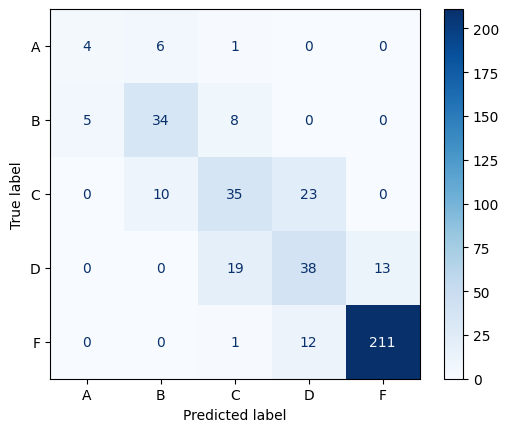

In [101]:
# Display SVM Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=svm_matrix, display_labels = grades)
disp.plot(cmap='Blues')

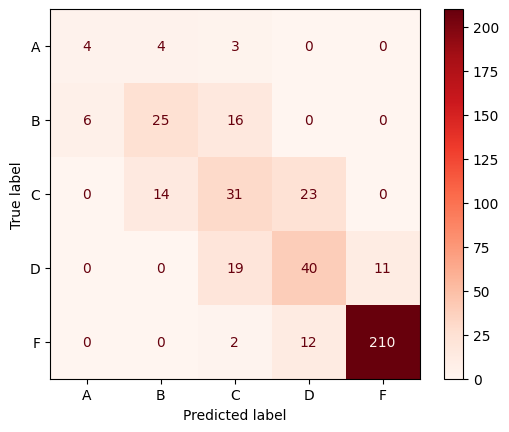

In [102]:
# Display RF Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=rf_matrix, display_labels = grades)
disp.plot(cmap='Reds')

In [103]:
accuracy = accuracy_score(label_test, prediction)
print(f"SVM Accuracy: {accuracy * 100:.2f}%")
accuracy = accuracy_score(label_test, rf_prediction)
print(f"RF Accuracy: {accuracy * 100:.2f}%")

SVM Accuracy: 76.67%
RF Accuracy: 73.81%


### **<ins>Outputing predictions to file</ins>**

In [104]:
# Read file
students = pd.read_csv('student_list.csv')

# Display students
students.head()

,StudentID,Age,StudyTimeWeekly,Absences,ParentalSupport,GPA,GradeClass
0,1002,18,15.408756,0,1,3.042915,1
1,1003,15,4.210570,26,2,0.112602,4
2,1004,17,10.028829,14,3,2.054218,3
3,1005,17,4.672495,17,3,1.288061,4
4,1006,18,8.191219,0,1,3.084184,1


In [105]:
# Attempt to find outliers
students.describe()

,StudentID,Age,StudyTimeWeekly,Absences,ParentalSupport,GPA,GradeClass
count,2100.000000,2100.000000,2079.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,2062.840952,16.475238,9.676082,14.709048,2.116190,1.892345,2.970476
std,626.957633,1.124823,5.667623,11.153253,1.120141,0.908335,1.245510
min,1002.000000,15.000000,0.004859,-122.000000,0.000000,0.000000,0.000000
25%,1526.750000,15.000000,4.895155,7.000000,1.000000,1.173660,2.000000
50%,2051.500000,16.000000,9.513101,15.000000,2.000000,1.883797,4.000000
75%,2576.250000,17.000000,14.324899,22.000000,3.000000,2.605279,4.000000
max,3392.000000,18.000000,19.978094,320.000000,4.000000,4.000000,4.000000


In [106]:
# Set all StudyTimeWeekly = NaN to the median of StudyTimeWeekly
students['StudyTimeWeekly'] = students['StudyTimeWeekly'].fillna(students['StudyTimeWeekly'].median())

# Assign features
new_features = sc.transform(students[["Age", "StudyTimeWeekly", "Absences", "ParentalSupport"]])

# Predict for new_features
grade_pred = svm_model.predict(new_features)
grade_pred

array(['B', 'F', 'D', ..., 'F', 'F', 'D'], shape=(2100,), dtype=object)

In [107]:
# Create new dataframe to store results
final_predictions = pd.DataFrame({
    'StudentID': students["StudentID"],
    'GradeClass': grade_pred
})
final_predictions

,StudentID,GradeClass
0,1002,B
1,1003,F
2,1004,D
3,1005,F
4,1006,B
...,...,...
2095,3386,F
2096,3388,B
2097,3390,F
2098,3391,F


In [108]:
######################################################
# Write predictions to csv file                      #
# Commented out to prevent overwriting existing file #
######################################################

final_predictions.to_csv('student_predictions.csv', index=False)